# `Midterm 2`, `Fall 2023`: `Punt, Kick, or Go for it?`
Revision history:   
_Version 1.0_: Initial release

*All of the header information is important. Please read it..*

**Topics, number of exercises:** This problem builds on your knowledge of mostly Pandas with a little NumPy. It has **9** exercises, numbered 0 to **8**. There are **21** available points. However, to earn 100% the threshold is **13** points. (Therefore, once you hit **13** points, you can stop. There is no extra credit for exceeding this threshold.)

**Exercise ordering:** Each exercise builds logically on previous exercises, but you may solve them in any order. That is, if you can't solve an exercise, you can still move on and try the next one. Use this to your advantage, as the exercises are **not** necessarily ordered in terms of difficulty. Higher point values generally indicate more difficult exercises. 

**Demo cells:** Code cells starting with the comment `### define demo inputs` load results from prior exercises applied to the entire data set and use those to build demo inputs. These must be run for subsequent demos to work properly, but they do not affect the test cells. The data loaded in these cells may be rather large (at least in terms of human readability). You are free to print or otherwise use Python to explore them, but we did not print them in the starter code.

**Debugging you code:** Right before each exercise test cell, there is a block of text explaining the variables available to you for debugging. You may use these to test your code and can print/display them as needed (careful when printing large objects, you may want to print the head or chunks of rows at a time).

**Exercise point breakdown:**

- Exercise 0: **2** point(s)
- Exercise 1: **2** point(s)
- Exercise 2: **2** point(s)
- Exercise 3: **2** point(s)
- Exercise 4: **3** point(s)
- Exercise 5: **2** point(s)
- Exercise 6: **3** point(s)
- Exercise 7: **2** point(s)
- Exercise 8: **3** point(s) - Depends on Exercise 7

**Final reminders:** 

- Submit after **every exercise**
- Review the generated grade report after you submit to see what errors were returned
- Stay calm, skip problems as needed, and take short breaks at your leisure


## Topic Introduction

### (Brief) Primer on American football

While this analysis is based on American football, having a deep knowledge of the intracices of the sport **is not necessary to complete this notebook.** Do not dwell on this primer information.
* A football game is a contest between two teams. One team is designated the "home" team and one team is designated the "away" team. The home/away designation will not change during the game. 
* Football games are timed. When the game clock reaches zero, the game ends, and the team with the higher score wins.
* One team possesses the ball at a time. This team is designated as the offense. The team designated as the offense will change during the course of the game.
* When the offense takes possession of the ball it gets 4 attempts to advance the ball to the line to gain. Each attempt is referred to as a "down". After the 4th down, if the offense has not advanced the ball to the line to gain the other team will take possession.
* If the offense advances the ball past the line to gain, they get another 4 downs and the line to gain is reset to 10 yards of where the progress stopped on the previous attempt.  
* On each down the offense has three options:
    * Run a play to attempt to advance the ball. There are many potential outcomes, Generally (but not always) the offense will either score a touchdown or retain possession of the ball.
    * Punt the ball to the other team. The ball advances, but the other team takes possession.
    * Attempt to kick a field goal. A successful attempt scores points, but an unsuccessful attempt will move the ball backwards and turn possession over to the other team.
    
### Our analysis
This framework makes the offense's decision on what to do on the fourth down an interesting question. We will provide data-driven guidance on which option (punting, kicking a field goal attempt, or running a play) will give the offense the best chance of winning the game.

In [1]:
### Global Imports

###
### AUTOGRADER TEST - DO NOT REMOVE
###

# Import required modules
# Feel free to import anything else you find useful
import pandas as pd
import dill as pickle
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from football_utils import *

# loading the raw data
with open('resource/asnlib/publicdata/all_events_df.pkl', 'rb') as f:
    all_events_df = pickle.load(f)

## A look at our data
We have sourced play level data from ESPN for over 2000 games from the 2000-2022 NFL seasons and loaded it into a Pandas DataFrame. The meanings of key columns are as follows:
- `play_id`, `drive_id`, `event_id` - Unique identifiers for a play, possession, and game respectively.
- `type` - the type of play which was run.
- `scoringPlay` - `True` if the result of a play was a score. `False` otherwise.
- `awayScore`, `homeScore` - the score of the home and away teams **after the play occurred**.
- `period` - the quarter in which the play started.
- `clock` - the time remaining in the quarter when the play started.
- `homeTeamPoss` - `True` if the home team is on offense when the play started.
- `down` - The down when the play started. 
- `distance` - the distance from the current position of the ball to the line to gain.
- `yardsToEndzone` - the distance from the current position of the ball to the endzone.

In [2]:
all_events_df.sample(5, random_state=6040)

,play_id,drive_id,event_id,sequenceNumber,type,poss_team_id,scoringPlay,awayScore,homeScore,period,clock,homeTeamPoss,down,distance,yardsToEndzone
99,4008746382403,40087463814,400874638,240300,Rush,6,False,10,10,3,9:48,True,2,2,53
154,4008745353875,40087453524,400874535,387500,Rush,29,False,20,31,4,9:48,True,1,10,15
27,401030721707,4010307216,401030721,70700,Rush,26,False,7,7,1,5:29,False,2,8,66
83,4011279702090,40112797010,401127970,209000,Field Goal Missed,34,False,7,17,2,0:02,False,1,10,38
26,400791570689,4007915705,400791570,68900,Pass Reception,34,False,7,0,1,4:13,True,2,11,26


In [3]:
all_events_df.dtypes

play_id           object
drive_id          object
event_id          object
sequenceNumber    object
type              object
poss_team_id      object
scoringPlay         bool
awayScore          int64
homeScore          int64
period             int64
clock             object
homeTeamPoss        bool
down               int64
distance           int64
yardsToEndzone     int64
dtype: object

## Exercise 0 - (**2** Points): 

To get a meaningful input for a model we need to convert the `period` and `clock` fields into a numerical measure of the time remaining in the game (in seconds). To do so we can apply the following formula:  

$$\text{timeLeft} = (15\times60)(4 - \text{period}) + 60(\text{clockMinutes}) + \text{clockSeconds}$$  

Define `calc_time_left(all_events_df: pd.DataFrame) -> pd.DataFrame`  

Input: `all_events_df` (DataFrame) - will contain `period` and `clock` fields. 
 - The `clock` field is a `str` with the format `'{clockMinutes}:{clockSeconds}'`. For example: `'9:48'` $\rightarrow$ $\text{clockMinutes} = 9$ and $\text{clockSeconds} = 48$

Your solution should parse the `clock` and `period` fields and return a _copy of_ `all_events_df` with a new field `timeLeft` (`dtype = 'int64'`) calculated per the formula above.   

In [4]:
### Define demo inputs
demo_all_events_df_ex0 = all_events_df\
    .sample(5, random_state=6040)\
    .copy()\
    .loc[:, ['event_id', 'period', 'clock']]

<!-- Expected demo output text block -->
The demo included in the solution cell below should display the following output:  
  
|     |   event_id |   period | clock   |   timeLeft |  
|----|-----------|---------|--------|-----------|  
|  99 |  400874638 |        3 | 9:48    |       1488 |  
| 154 |  400874535 |        4 | 9:48    |        588 |  
|  27 |  401030721 |        1 | 5:29    |       3029 |  
|  83 |  401127970 |        2 | 0:02    |       1802 |  
|  26 |  400791570 |        1 | 4:13    |       2953 |  

<!-- Include any shout outs here -->

In [5]:
### Exercise 0 solution
import copy
def calc_time_left(all_events_df: pd.DataFrame) -> pd.DataFrame:
    ###
    newDF = all_events_df.copy(deep=True)
    timeLeft = []
    clockMins = 0
    for i in range(len(newDF['clock'])):
        if len(newDF.iloc[i]['clock']) == 4:
            clockMins = int(newDF.iloc[i]['clock'][0])
        else:
            clockMins = int(newDF.iloc[i]['clock'][:2])
        clockSecs = int(newDF.iloc[i]['clock'][len(newDF.iloc[i]['clock'])-2:])
        period = int(newDF.iloc[i]['period'])
        timeLeft.append(((15*60)*(4-period))+(60*(clockMins))+clockSecs)
    newDF['timeLeft'] = timeLeft
    return newDF
    ###
    
### demo function call
calc_time_left(demo_all_events_df_ex0)

,event_id,period,clock,timeLeft
99,400874638,3,9:48,1488
154,400874535,4,9:48,588
27,401030721,1,5:29,3029
83,401127970,2,0:02,1802
26,400791570,1,4:13,2953


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 0. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [6]:
### test_cell_ex0
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_0', 
    'func': calc_time_left, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'all_events_df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'pd.DataFrame',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


The cell below will load the data with the `timeLeft` field added. If your solution is correct this data is equivalent to running the following code. (Don't run it in your exam as it takes some time to run on the full data).  

```
time_all_events_df = calc_time_left(all_events_df)
```

In [7]:
with open('resource/asnlib/publicdata/time_all_events_df.pkl', 'rb') as f:
    time_all_events_df = pickle.load(f).reset_index(drop=True)

## Exercise 1 - (**2** Points): 
Our data includes some records which are not actually plays and should not be considered in our analysis. Additionally, some of the games went into an extra period due to being tied when the time left was zero. Any game which went into the extra period also will not be considered in our analysis.  

Define `filter_non_plays_and_ot(df: pd.DataFrame) -> pd.DataFrame`
- Input: `df` (DataFrame) - will contain `type`, `timeLeft`, and `event_id` fields.   

Your solution should do the following:  
  - Identify all rows with a `type` value that is in `non_play_types` (supplied in starter code). (Call these `non_play_rows`)
  - Identify all unique `event_id` values occurring in rows where `timeLeft` is less than zero. (Call these `ot_event_ids`).
  - Identify all rows where the `event_id` value is in `ot_event_ids`. (Call these `ot_event_rows`)
  - Return _a copy_ of `df` with `non_play_rows` and `ot_event_rows` filtered out.
  
**Note** - you do not need to worry about the case where your solution filters out all of the rows in the input. This is not expected when applying this filter on the real data and will not be tested.

In [8]:
### Define demo inputs
with open('resource/asnlib/publicdata/demo_df_ex1.pkl', 'rb') as f:
    demo_df_ex1 = pickle.load(f)
demo_df_ex1

,type,timeLeft,event_id
0,Punt,-830,401127999
1,Two Point Rush,0,400874631
2,Two-minute warning,1920,401437889
3,Rush,976,401220231
4,Timeout,332,400951744
5,Rush,3533,401127999
6,End Period,900,401220213
7,Rushing Touchdown,3165,400554399
8,Timeout,1533,401249063
9,Timeout,51,401437866


<!-- Expected demo output text block -->
The demo included in the solution cell below should display the following output:  

|    | type              |   timeLeft |   event_id |  
|---:|:------------------|-----------:|-----------:|  
|  3 | Rush              |        976 |  401220231 |  
|  7 | Rushing Touchdown |       3165 |  400554399 |  
| 13 | Rush              |        792 |  400874553 |  
| 17 | Pass Reception    |        926 |  401437633 |  

Notice that row 0 has a negative `timeLeft` and has an `event_id` of `'401127999'`. Since row 5 also has `event_id` of `'401127999'` it is also excluded.

In [9]:
### Exercise 1 solution
def filter_non_plays_and_ot(df: pd.DataFrame) -> pd.DataFrame:
    non_play_types = ['Penalty', 'End Period', 'Two-minute warning', 'Timeout', 'End of Half',
                      'End of Game', 'Official Timeout', 'Defensive 2pt Conversion', 
                      'Two Point Rush', 'Extra Point Good']
    ###
    plays = ~df['type'].isin(non_play_types) #tilde means "not" --> all plays that are valid their index = True
    ot_events = df.loc[df['timeLeft'] < 0, 'event_id'].unique() #list of OT events by event_ID
    ends_in_regulation = ~df['event_id'].isin(ot_events) #generates all regulation events where event ID not in OT_events
    return df.loc[plays & ends_in_regulation, :]
    ###
    
### demo function call
filter_non_plays_and_ot(demo_df_ex1)

,type,timeLeft,event_id
3,Rush,976,401220231
7,Rushing Touchdown,3165,400554399
13,Rush,792,400874553
17,Pass Reception,926,401437633


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 1. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [10]:
### test_cell_ex1
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_1', 
    'func': filter_non_plays_and_ot, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


In [11]:
with open('resource/asnlib/publicdata/filtered_all_events_df.pkl', 'rb') as f:
    filtered_all_events_df = pickle.load(f).reset_index(drop=True)

## Exercise 2 - (**2** Points): 
One thing which we will have to model in our analysis is the probability that the offense will advance the ball to the line to gain (referred to as converting) based on the distance to that line at the start of a play. In the data, a row which was converted will meet these criteria: 
1. The next row (based on descending `timeLeft`) shares the same `drive_id`
2. The next row (based on descending `timeLeft`) either
  - has `down` equal to `1` or 
  - has `scoringPlay==True` and one of some specific `type` values

To simplify this calculation, we have provided a helper function `converted_by_drive(group: pd.DataFrame) -> pd.DataFrame`. This function expects the input `group` to be a DataFrame containing **_only records from the same drive_ (i.e. sharing a common `drive_id` value)**. It will return a DataFrame with the new column `converted` added as specified above.

**Your task**:
Define `converted(event_df: pd.DataFrame) -> pd.DataFrame`.  
- Input: `event_df` (DataFrame) - will contain the fields `drive_id`, `type`, `scoringPlay`, `down`, and `timeLeft` fields.  

Your solution should do the following:  
- Partition `event_df` by `drive_id`.
- Apply `converted_by_drive` to each partition.
- Concatenate the results back into a single DataFrame
- Return the result.
  - Your result should have the same columns and `dtypes` attributes as `event_df` with the addition of the `converted` field.
  
**Hint:** [`pd.DataFrame.GroupBy.apply`](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.core.groupby.GroupBy.apply.html) will be _very useful_ in solving this exercise. It can take care of the partition, apply, and concatenate steps.

In [12]:
### Define demo inputs
with open('resource/asnlib/publicdata/demo_event_df_ex2.pkl', 'rb') as f:
    demo_event_df_ex2 = pickle.load(f)

<!-- Expected demo output text block -->
The demo data has 3 unique `drive_id` values. After partitioning, there are 3 DataFrames:  

---

`drive_id`: 4014356411  

|    |   drive_id | type                     | scoringPlay   |   down |   timeLeft |  
|---:|-----------:|:-------------------------|:--------------|-------:|-----------:|  
|  0 | 4014356411 | Kickoff Return (Offense) | False         |      0 |       3600 |  
|  1 | 4014356411 | Pass Incompletion        | False         |      1 |       3594 |  
|  2 | 4014356411 | Rush                     | False         |      2 |       3589 |  
|  3 | 4014356411 | Sack                     | False         |      3 |       3547 |  
|  4 | 4014356411 | Punt                     | False         |      4 |       3515 |  

`drive_id`: 4014356414  

|    |   drive_id | type              | scoringPlay   |   down |   timeLeft |  
|---:|-----------:|:------------------|:--------------|-------:|-----------:|  
| 12 | 4014356414 | Pass Reception    | False         |      1 |       3336 |  
| 13 | 4014356414 | Rush              | False         |      2 |       3304 |  
| 14 | 4014356414 | Rush              | False         |      2 |       3288 |  
| 15 | 4014356414 | Rush              | False         |      1 |       3248 |  
| 16 | 4014356414 | Pass Reception    | False         |      2 |       3207 |  
| 17 | 4014356414 | Passing Touchdown | True          |      3 |       3160 |  

`drive_id`: 4014356418  

|    |   drive_id | type              | scoringPlay   |   down |   timeLeft |  
|---:|-----------:|:------------------|:--------------|-------:|-----------:|  
| 44 | 4014356418 | Pass Incompletion | False         |      1 |       2452 |  
| 45 | 4014356418 | Rush              | False         |      2 |       2448 |  
| 46 | 4014356418 | Rush              | False         |      1 |       2412 |  
| 47 | 4014356418 | Pass Incompletion | False         |      2 |       2370 |  
| 48 | 4014356418 | Pass Reception    | False         |      3 |       2362 |  
| 49 | 4014356418 | Field Goal Good   | True          |      4 |       2323 |  

---

After calling `converted_by_drive` on each partition and concatenating the results your solution should output.   

|    |   drive_id | type                     | scoringPlay   |   down |   timeLeft | converted   |  
|---:|-----------:|:-------------------------|:--------------|-------:|-----------:|:------------|  
|  0 | 4014356411 | Kickoff Return (Offense) | False         |      0 |       3600 | True        |  
|  1 | 4014356411 | Pass Incompletion        | False         |      1 |       3594 | False       |  
|  2 | 4014356411 | Rush                     | False         |      2 |       3589 | False       |  
|  3 | 4014356411 | Sack                     | False         |      3 |       3547 | False       |  
|  4 | 4014356411 | Punt                     | False         |      4 |       3515 | False       |  
|  5 | 4014356414 | Pass Reception           | False         |      1 |       3336 | False       |  
|  6 | 4014356414 | Rush                     | False         |      2 |       3304 | False       |  
|  7 | 4014356414 | Rush                     | False         |      2 |       3288 | True        |  
|  8 | 4014356414 | Rush                     | False         |      1 |       3248 | False       |  
|  9 | 4014356414 | Pass Reception           | False         |      2 |       3207 | False       |  
| 10 | 4014356414 | Passing Touchdown        | True          |      3 |       3160 | True        |  
| 11 | 4014356418 | Pass Incompletion        | False         |      1 |       2452 | False       |  
| 12 | 4014356418 | Rush                     | False         |      2 |       2448 | True        |  
| 13 | 4014356418 | Rush                     | False         |      1 |       2412 | False       |  
| 14 | 4014356418 | Pass Incompletion        | False         |      2 |       2370 | False       |  
| 15 | 4014356418 | Pass Reception           | False         |      3 |       2362 | False       |  
| 16 | 4014356418 | Field Goal Good          | True          |      4 |       2323 | False       |  

  
**Note** some of you who _are_ familiar with the sport will notice that this solution incorrectly treats a kickoff return as a conversion. That _is correct_, but this will not affect our modeling or analysis because of some filtering that happens later on in the notebook.

In [13]:
### Exercise 2 solution

### Helper function provided as part of the starter code
def converted_by_drive(group: pd.DataFrame) -> pd.DataFrame:
    group = group.sort_values('timeLeft', ascending=False)\
        .reset_index(drop=True)
    offensive_touchdown_types = ['Passing Touchdown', 'Rushing Touchdown', 
                             'Fumble Recovery (Own)', 'Rush', 'Pass Reception']
    # `pd.DataFrame.shift` might be useful later...
    first_downs = (group['down'] == 1).shift(-1, fill_value=False)
    scores = (group['scoringPlay'] == True)&(group['type'].isin(offensive_touchdown_types))
    group['converted'] = (first_downs|scores)
    return group

### Your solution
def converted(event_df: pd.DataFrame) -> pd.DataFrame:
    ###
    df = event_df.groupby('drive_id', as_index=False).apply(converted_by_drive)
    return (df.reset_index(drop=True))
    ###
    
converted(demo_event_df_ex2)

,drive_id,type,scoringPlay,down,timeLeft,converted
0,4014356411,Kickoff Return (Offense),False,0,3600,True
1,4014356411,Pass Incompletion,False,1,3594,False
2,4014356411,Rush,False,2,3589,False
3,4014356411,Sack,False,3,3547,False
4,4014356411,Punt,False,4,3515,False
5,4014356414,Pass Reception,False,1,3336,False
6,4014356414,Rush,False,2,3304,False
7,4014356414,Rush,False,2,3288,True
8,4014356414,Rush,False,1,3248,False
9,4014356414,Pass Reception,False,2,3207,False


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 2. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [14]:
### test_cell_ex2
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_2', 
    'func': converted, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'event_df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


In [15]:
with open('resource/asnlib/publicdata/converted_all_events_df.pkl', 'rb') as f:
    converted_all_events_df = pickle.load(f)

## Exercise 3 - (**2** Points): 
We are interested in modeling win probability. As such, it makes sense to create a **column indicating whether the team on offense (i.e. the home team when** `homeTeamPoss` **is** `True` **and the away team when** `homeTeamPoss` **is** `False`**) for a particular play eventually won the game.**

Define the function `who_won(event_df: pd.DataFrame) -> pd.DataFrame`.  
- Input: event_df (DataFrame) - will contain the fields `awayScore`, `homeScore`, `homeTeamPoss`, and `timeLeft`.  
  - You can assume that all records from `event_df` are from the same game.  
  
Your solution should do the following:  
- Identify the home and away scores at the end of the game. You can do this either by sorting based on `timeLeft` or by finding the maximum score for each team.  
- Determine which team (home team or away team) had the higher score at the end of the game.
- Your solution should return a _copy of_ `event_df` with a new column `won` that is set to `True` where the team on offense won the game and `False` if the other won the game.  
  - If the home team won then `won` will have the same values as `homeTeamPoss`.
  - If the away team won then `won` will have the opposite values of `homeTeamPoss`.

In [16]:
### Define demo inputs
with open('resource/asnlib/publicdata/demo_event_df_ex3.pkl', 'rb') as f:
    demo_event_df_ex3 = pickle.load(f).drop(columns='index')
with open('resource/asnlib/publicdata/demo_soln_ex3.pkl', 'rb') as f:
    true_demo_soln_ex3 = pickle.load(f)
display(demo_event_df_ex3.head())
display(demo_event_df_ex3.tail())

,awayScore,homeScore,homeTeamPoss,timeLeft
0,0,0,True,3600
1,0,0,False,3600
2,0,0,False,3559
3,0,0,False,3523
4,0,0,False,3490


,awayScore,homeScore,homeTeamPoss,timeLeft
139,6,26,False,149
140,6,26,False,121
141,6,26,True,111
142,6,26,True,66
143,6,26,True,31


<!-- Expected demo output text block -->
The demo included in the solution cell below should display the following output:  

|    |   awayScore |   homeScore | homeTeamPoss   |   timeLeft | won   |  
|---:|------------:|------------:|:---------------|-----------:|:------|  
|  0 |           0 |           0 | True           |       3600 | True  |  
|  1 |           0 |           0 | False          |       3600 | False |  
|  2 |           0 |           0 | False          |       3559 | False |  
|  3 |           0 |           0 | False          |       3523 | False |  
|  4 |           0 |           0 | False          |       3490 | False |  

---

|     |   awayScore |   homeScore | homeTeamPoss   |   timeLeft | won   |  
|----:|------------:|------------:|:---------------|-----------:|:------|  
| 139 |           6 |          26 | False          |        149 | False |  
| 140 |           6 |          26 | False          |        121 | False |  
| 141 |           6 |          26 | True           |        111 | True  |  
| 142 |           6 |          26 | True           |         66 | True  |  
| 143 |           6 |          26 | True           |         31 | True  |  

Since the `homeScore` at the end of the game is more than the `awayScore` the home team won the game. Thus the `won` column is the same as the `homeTeamPoss` column. **It is also worth mentioning that while this demo data is pre-sorted, that may not be the case when we test your solution.**

**Note** that this is just the `head` and `tail` of the full demo result. We have loaded the true result into `true_demo_soln_ex3` if you want to do a full comparison.


In [17]:
### Exercise 3 solution
def who_won(event_df: pd.DataFrame) -> pd.DataFrame:
    ###
    won = pd.Series(object)
    event_df2 = event_df.sort_values(by='timeLeft', ascending=False)
    if max(event_df2['homeScore']) > max(event_df2['awayScore']):
        won = event_df2['homeTeamPoss']
    else:
        won = ~event_df2['homeTeamPoss']
    event_df2['won'] = won
    return event_df2
    ###
    
### demo function call
demo_soln_ex3 = who_won(demo_event_df_ex3)
    
display(demo_soln_ex3.head())
display(demo_soln_ex3.tail())

,awayScore,homeScore,homeTeamPoss,timeLeft,won
0,0,0,True,3600,True
1,0,0,False,3600,False
2,0,0,False,3559,False
3,0,0,False,3523,False
4,0,0,False,3490,False


,awayScore,homeScore,homeTeamPoss,timeLeft,won
139,6,26,False,149,False
140,6,26,False,121,False
141,6,26,True,111,True
142,6,26,True,66,True
143,6,26,True,31,True


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 3. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [18]:
### test_cell_ex3
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_3', 
    'func': who_won, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'event_df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


In [19]:
with open('resource/asnlib/publicdata/winners_all_events_df.pkl', 'rb') as f:
    winners_all_events_df = pickle.load(f)

## Exercise 4 - (**3** Points): 
Yet another thing we have to model is the "expected points". As a pre-requisite to that we need to know what the next score after each play is. 

We have provided `get_update_list(df: pd.DataFrame) -> list` to help you. 
- This function takes a DataFrame input. It is expected that `df` is the play data for a single game _and_ that `df` is sorted by `timeLeft` in descending order. 
- It returns a list of tuples. **You should interpret each tuple `(a, b)` to mean "on the `(a-1)`-th play, the score changed `b` points in favor of the _home team_."** 
- If `(a,x)` and `(b,y)` are a pair of consecutive tuples in the output, then **rows `a` through `b-1`** should have the `nextScore` value of **`y` when `homeTeamPoss` is `True`** and **`-y` when `homeTeamPoss` is `False`**

**Your task**
Define the function `add_next_score(event_df: pd.DataFrame) -> pd.DataFrame`
- Input: `event_df` (DataFrame) - will have the fields `awayScore`, `homeScore`, `scoringPlay`, `timeLeft`, and `homeTeamPoss`.  

Your solution should do the following:  
- Copy `event_df`, sort the copy by `timeLeft` in descending order, and reset the index. We will call this copy `df`.
- Call `get_update_list` on the `df`. We will call the output `update_list`.
- Create a new column `nextScore` in `df`. Set the values of `nextScore` based on the `update_list`. **Hint: clever use of the** `zip` **function and slicing of** `update_list` **will make this an easy task.**
- Negate `df['nextScore']` in all rows where `df['homeTeamPoss']` is `True`
- Return `df`

In [20]:
### Define demo inputs
def get_update_list(df: pd.DataFrame) -> list:
    scoring = df.loc[df['scoringPlay'], ['awayScore', 'homeScore']]
    scoring[['previousAway', 'previousHome']] = scoring.shift(1, fill_value=0) 
    scoring['next_score'] = (scoring['homeScore'] - scoring['previousHome']) - \
        (scoring['awayScore'] - scoring['previousAway'])
    return[(0, 0), *[(k+1, v) for k, v in scoring['next_score'].to_dict().items()], (len(df), 0)]

with open('resource/asnlib/publicdata/demo_output_ex4.pkl', 'rb') as f:
    true_demo_output_ex4 = pickle.load(f)

with open('resource/asnlib/publicdata/demo_event_df_ex4.pkl', 'rb') as f:
    demo_event_df_ex4 = pickle.load(f)

<!-- Expected demo output text block -->
The demo data in `demo_event_df_ex4` has been pre-sorted for demonstration. Your solution will need to take care of the sorting as data given by the test cell will not be sorted.

If we call `get_update_list(demo_event_df_ex4)`, we will get this output.
```
[(0, 0), (11, -3), (18, -7), (20, -3), (23, 7), (25, -3), (30, 7), (31, 0)] 
```  
- Rows 0 through 10 should reflect a next score of -3 when `homeTeamPoss` is `True` and 3 otherwise
  - Note: The first tuple `(0,0)` indicates the start of the game.
- Rows 11 through 17 should reflect a next score of -7 when `homeTeamPoss` is `True` and 7 otherwise
- Rows 18 through 19 should reflect a next score of -3 when `homeTeamPoss` is `True` and 3 otherwise
- Rows 20 through 22 should reflect a next score of 7 when `homeTeamPoss` is `True` and -7 otherwise
- Rows 23 through 24 should reflect a next score of -3 when `homeTeamPoss` is `True` and 3 otherwise
- Rows 25 through 29 should reflect a next score of 7 when `homeTeamPoss` is `True` and -7 otherwise
- Rows 30 through 31 should reflect a next score of 0 when `homeTeamPoss` is `True` and 0 otherwise
  - Note: The last tuple `(x, 0)` indicates the end of the game.
  
Applying this logic to our input we get the following demo output:
  
|    |   awayScore |   homeScore |   timeLeft | scoringPlay   | homeTeamPoss   |   nextScore |  
|---:|------------:|------------:|-----------:|:--------------|:---------------|------------:|  
|  0 |   0 |       0 |   3477 | False     | False      |       3 |  
|  1 |           0 |           0 |       3358 | False         | True           |          -3 |  
|  2 |           0 |           0 |       3239 | False         | True           |          -3 |  
|  3 |           0 |           0 |       3115 | False         | True           |          -3 |  
|  4 |           0 |           0 |       3002 | False         | False          |           3 |  
|  5 |           0 |           0 |       2885 | False         | False          |           3 |  
|  6 |           0 |           0 |       2767 | False         | False          |           3 |  
|  7 |           0 |           0 |       2650 | False         | True           |          -3 |  
|  8 |           0 |           0 |       2534 | False         | False          |           3 |  
|  9 |           0 |           0 |       2413 | False         | False          |           3 |  
| **10** |     **3**|       **0** |   **2299** | **True**      | **False**      |       **3** |  
| 11 |           3 |           0 |       2182 | False         | False          |           7 |  
| 12 |           3 |           0 |       2065 | False         | True           |          -7 |  
| 13 |           3 |           0 |       1949 | False         | True           |          -7 |  
| 14 |           3 |           0 |       1826 | False         | True           |          -7 |  
| 15 |           3 |           0 |       1707 | False         | True           |          -7 |  
| 16 |           3 |           0 |       1594 | False         | False          |           7 |  
| **17** |  **10** |       **0** |   **1471** | **True**      | **True**       |      **-7** |  
| 18 |          10 |           0 |       1348 | False         | True           |          -3 |  
| **19** |          **13** |           **0** |       **1230** | **True**   | **False**  | **3** |  
| 20 |          13 |           0 |       1106 | False         | True           |           7 |  
| 21 |          13 |           0 |        987 | False         | True           |           7 |  
| **22** |  **13** |       **7** |    **867** | **True**      | **False**      |      **-7** |  
| 23 |          13 |           7 |        746 | False         | True           |          -3 |  
| **24** |  **16** |       **7** |    **625** | **True**      | **True**       |      **-3** |  
| 25 |          16 |           7 |        503 | False         | False          |          -7 |  
| 26 |          16 |           7 |        383 | False         | False          |          -7 |  
| 27 |          16 |           7 |        265 | False         | True           |           7 |  
| 28 |          16 |           7 |        147 | False         | False          |          -7 |  
| **29** |  **16** |      **14** |     **26** | **True**      | **True**       |       **7** | 
| 30 |          16 |          14 |          0 | False         | True           |           0 |  

Note: The demo will not actually display your output. Rather it gets loaded into the variable `demo_output_ex4`. We have loaded the expected result into `true_demo_output_ex4` for you to compare on your own if you desire.

In [21]:
### Exercise 4 solution
def add_next_score(event_df: pd.DataFrame) -> pd.DataFrame:
    ###
    df = event_df.copy(deep=True)
    df = df.sort_values(by='timeLeft', ascending=False)
    df = df.reset_index(drop=True)
    
    update_list = get_update_list(df)
#     for start, end in zip(update_list[:-1], update_list[1:]):
#         df.loc[(start[0]):(end[0]), 'nextScore'] = end[1]
#         print(df)
#     df.loc[~df['homeTeamPoss'], 'nextScore'] = -1*df.loc[~df['homeTeamPoss'], 'nextScore']
#     df['nextScore'] = df['nextScore'].astype(int)

#     return df  
    dataFrameLst = []
    for i in range(1, len(update_list)):
        tru = df[update_list[i-1][0]:update_list[i][0]]
        ser = pd.Series(int)
        ser = update_list[i][1]
        tru['nextScore'] = ser
        dataFrameLst.append(tru)
    result = pd.concat(dataFrameLst)
    result.loc[~result['homeTeamPoss'], 'nextScore'] = -1*result.loc[~df['homeTeamPoss'], 'nextScore']
    result['nextScore'] = result['nextScore'].astype(int)

    return (result)
    ###
    
### demo function call
demo_output_ex4 = add_next_score(demo_event_df_ex4)
# print(true_output_vars['output_0'])
# print(returned_output_vars['output_0'])

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 4. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [22]:
### test_cell_ex4
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_4', 
    'func': add_next_score, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'event_df':{
            'dtype':'', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Passed! Please submit.


<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tru['nextScore'] = ser
<ipython-input-21-9f394e39b2a2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

## Exercise 5 - (**2** Points): 
The score fields (`homeScore` and `awayScore`) indicate the score **after the play occurred**. In order to use the scores as inputs to a model we need to add a lag so that they indicate the score _before the play occurred_.

Define `lag_score(all_events_df: pd.DataFrame) -> pd.DataFrame`  
- Input: all_events_df (DataFrame) - will contain fields `event_id`, `timeLeft`, `awayScore`, `homeScore`  
- `all_events_df['event_id']` is expected to have multiple distinct values. _You can not assume that all of the records are from the same game._

Your solution should do the following:
- Copy `all_events_df` and sort it by `event_id` and `timeLeft`. The order of `event_id` doesn't matter (sorting helps things run faster). However, sorting the records _for each event_ by `timeLeft` _in descending order_ is critical (which is why we must sort by both columns). We will call the sorted copy `df`.  
- Partition `df` by `event_id`.
- For each partition, set the `homeScore` and `awayScore` values to their values from one row prior. Since the first row has no rows which are prior to it, we will set both score values to 0.
  - **Hint** - The [pd.DataFrame.shift](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.DataFrame.shift.html) method will be helpful in accomplishing this step.
- Concatenate the partitions together.
- Return the result.

**Hint** - The pattern of making a helper function to introduce the lag for a single game and using it with [`pd.DataFrame.GroupBy.apply`](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.core.groupby.GroupBy.apply.html) will be very helpful in solving this exercise.

In [23]:
### Define demo inputs

with open('resource/asnlib/publicdata/demo_all_events_df_ex5.pkl', 'rb') as f:
    demo_all_events_df_ex5 = pickle.load(f)
demo_all_events_df_ex5

,awayScore,homeScore,timeLeft,event_id
0,0,0,3001,401030893
1,3,0,2400,401030893
2,3,7,1803,401030893
3,3,7,1206,401030893
4,3,7,608,401030893
5,3,7,4,401030893
6,10,7,0,401030893
7,3,0,3002,401030897
8,3,0,2396,401030897
9,3,7,1794,401030897


<!-- Expected demo output text block -->

**Note**: The demo input is pre-sorted. The inputs in the test will not be.

The demo included in the solution cell below should display the following output:  


|    |   awayScore |   homeScore |   timeLeft |   event_id |  
|---:|------------:|------------:|-----------:|-----------:|  
|  0 |           0 |           0 |       3001 |  401030893 |  
|  1 |           0 |           0 |       2400 |  401030893 |  
|  2 |           3 |           0 |       1803 |  401030893 |  
|  3 |           3 |           7 |       1206 |  401030893 |  
|  4 |           3 |           7 |        608 |  401030893 |  
|  5 |           3 |           7 |          4 |  401030893 |  
|  6 |           3 |           7 |          0 |  401030893 |  
|  7 |           0 |           0 |       3002 |  401030897 |  
|  8 |           3 |           0 |       2396 |  401030897 |  
|  9 |           3 |           0 |       1794 |  401030897 |  
| 10 |           3 |           7 |       1194 |  401030897 |  
| 11 |           3 |           7 |        590 |  401030897 |  
| 12 |           3 |          10 |          0 |  401030897 |  

Notice that the scores have moved down one row _for each `event_id`_. 

In [24]:
### Exercise 5 solution
def lag_score(all_events_df: pd.DataFrame) -> pd.DataFrame:
    ###
    def helper_shift(df):
        df['homeScore'] = df['homeScore'].shift(1, fill_value=0)
        df['awayScore'] = df['awayScore'].shift(1, fill_value=0)
        return df
    
    df = all_events_df.copy(deep=True)
    df = df.sort_values(by=['event_id','timeLeft'], ascending=False)

    lag_df = df.groupby('event_id', as_index=False).apply(helper_shift)
    return lag_df
    ###
    
### demo function call
# call the function defined above using the demo inputs.
# print the result
ballhero = lag_score(demo_all_events_df_ex5)
print(ballhero)

    awayScore  homeScore  timeLeft   event_id
7           0          0      3002  401030897
8           3          0      2396  401030897
9           3          0      1794  401030897
10          3          7      1194  401030897
11          3          7       590  401030897
12          3         10         0  401030897
0           0          0      3001  401030893
1           0          0      2400  401030893
2           3          0      1803  401030893
3           3          7      1206  401030893
4           3          7       608  401030893
5           3          7         4  401030893
6           3          7         0  401030893


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 5. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [25]:
### test_cell_ex5
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_5', 
    'func': lag_score, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'all_events_df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


In [26]:
with open('resource/asnlib/publicdata/lag_all_events.pkl', 'rb') as f:
    lag_all_events = pickle.load(f)

## Exercise 6 - (**3** Points): 
We're almost done preparing the data for our modeling steps. We need to do some final filtering to create three DataFrames: `conversion_data`, `ep_data`, and `wp_data`.

Define the function `build_model_inputs(all_events_df: pd.DataFrame) -> pd.DataFrame, pd.DataFrame, pd.DataFrame`  
- Input: `all_events_df` - will include these fields: `'distance', 'nextScore', 'timeLeft', 'play_id', 'won', 'homeTeamPoss', 'awayScore', 'converted', 'down', 'yardsToEndzone', 'event_id', 'homeScore'`  

Your solution should do the following:  
- Copy `all_events_df`. We will call this `df`.
- Identify all rows where `df['down']` is 0. Filter them out of `df`.
- Calculate `conversion_data` from `df`.
  - should include only fields in `conversion_fields` (part of the startercode)
  - should only include rows where `df['down']` is 3 or 4
  - should not include rows which are have "field goal" in `df['type'].lower()`.
  - should not include rows which are have "punt" mentioned in `df['type'].lower()`.
- Calculate `ep_data` from `df`
  - `ep_data` should include only fields in `ep_fields` (part of startercode)
- Calculate `wp_data` from `df`  
  - `wp_data` should include only fields in `wp_fields` (part of startercode)
- Return `conversion_data`, `ep_data` and `wp_data`

In [27]:
### Define demo inputs

with open('resource/asnlib/publicdata/demo_all_events_df_ex6', 'rb') as f:
    demo_all_events_df_ex6 = pickle.load(f)
demo_all_events_df_ex6

,event_id,play_id,type,down,distance,yardsToEndzone,timeLeft,awayScore,homeScore,homeTeamPoss,won,converted,nextScore
0,401030904,4008747201193,Pass Reception,3,11,91,954,6,14,False,False,False,-3
1,401326450,4010307031458,Pass Incompletion,1,10,70,3072,0,0,False,False,False,-7
2,400554237,4009516971438,Rush,3,1,51,1300,13,10,True,False,True,3
3,400951717,4005543092779,Pass Reception,2,5,59,1984,0,17,False,True,True,7
4,400951697,4010309042694,Field Goal Good,4,6,33,797,13,6,False,True,False,3
5,401326489,401326450587,Field Goal Missed,4,11,21,3231,0,0,False,False,False,-3
6,400554309,400554237276,Kickoff,0,0,65,2282,0,0,True,True,True,7
7,400874720,4013264892550,Pass Reception,1,10,75,380,22,31,False,False,True,7
8,401030695,4010306953412,Punt,4,10,43,2257,7,14,True,True,False,-3
9,401030703,4009517172741,Rushing Touchdown,4,1,1,1144,21,7,False,True,True,7


<!-- Expected demo output text block -->
The demo included in the solution cell below should display the following output for `conversion_data`, `ep_data`, and `wp_data` respectively:  

|    |   event_id |       play_id |   down |   distance | converted   |  
|---:|-----------:|--------------:|-------:|-----------:|:------------|  
|  0 |  401030904 | 4008747201193 |      3 |         11 | False       |  
|  2 |  400554237 | 4009516971438 |      3 |          1 | True        |  
|  9 |  401030703 | 4009517172741 |      4 |          1 | True        |  

|    |   event_id |       play_id |   down |   distance |   yardsToEndzone |   nextScore |  
|---:|-----------:|--------------:|-------:|-----------:|-----------------:|------------:|  
|  0 |  401030904 | 4008747201193 |      3 |         11 |               91 |          -3 |  
|  1 |  401326450 | 4010307031458 |      1 |         10 |               70 |          -7 |  
|  2 |  400554237 | 4009516971438 |      3 |          1 |               51 |           3 |  
|  3 |  400951717 | 4005543092779 |      2 |          5 |               59 |           7 |  
|  4 |  400951697 | 4010309042694 |      4 |          6 |               33 |           3 |  
|  5 |  401326489 |  401326450587 |      4 |         11 |               21 |          -3 |  
|  7 |  400874720 | 4013264892550 |      1 |         10 |               75 |           7 |  
|  8 |  401030695 | 4010306953412 |      4 |         10 |               43 |          -3 |  
|  9 |  401030703 | 4009517172741 |      4 |          1 |                1 |           7 |  

|    |   event_id |       play_id |   down |   distance |   yardsToEndzone |   timeLeft |   awayScore |   homeScore | homeTeamPoss   | won   |
|---:|-----------:|--------------:|-------:|-----------:|-----------------:|-----------:|------------:|------------:|:---------------|:------|
|  0 |  401030904 | 4008747201193 |      3 |         11 |               91 |        954 |           6 |          14 | False          | False |
|  1 |  401326450 | 4010307031458 |      1 |         10 |               70 |       3072 |           0 |           0 | False          | False |
|  2 |  400554237 | 4009516971438 |      3 |          1 |               51 |       1300 |          13 |          10 | True           | False |
|  3 |  400951717 | 4005543092779 |      2 |          5 |               59 |       1984 |           0 |          17 | False          | True  |
|  4 |  400951697 | 4010309042694 |      4 |          6 |               33 |        797 |          13 |           6 | False          | True  |
|  5 |  401326489 |  401326450587 |      4 |         11 |               21 |       3231 |           0 |           0 | False          | False |
|  7 |  400874720 | 4013264892550 |      1 |         10 |               75 |        380 |          22 |          31 | False          | False |
|  8 |  401030695 | 4010306953412 |      4 |         10 |               43 |       2257 |           7 |          14 | True           | True  |
|  9 |  401030703 | 4009517172741 |      4 |          1 |                1 |       1144 |          21 |           7 | False          | True  |
<!-- Include any shout outs here -->

In [28]:
### Exercise 6 solution
def build_model_inputs(all_events_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
#     pd.options.mode.chained_assignment = None  # default='warn'
    conversion_fields = ['event_id', 'play_id', 'down', 'distance', 'converted']
    ep_fields = ['event_id', 'play_id', 'down', 'distance', 'yardsToEndzone', 'nextScore']
    win_prob_fields = ['event_id', 'play_id', 'down', 'distance', 'yardsToEndzone', 
                       'timeLeft', 'awayScore', 'homeScore', 'homeTeamPoss', 'won']
    ###
    df = all_events_df.copy(deep=True)
    df = df.query('down != 0')
    
    nonConversion_fields = [c for c in list(df.columns) if c not in conversion_fields]
    df['type'] = df['type'].str.lower()
    conversion_data = df[~df['type'].str.contains("field goal")]
    conversion_data = conversion_data[~conversion_data['type'].str.contains("punt")]
    conversion_data = conversion_data.drop(labels=nonConversion_fields, axis=1, inplace=False)
    conversion_data = conversion_data.query('down>2')
    
    nonEpData = [c for c in list(df.columns) if c not in ep_fields]
    ep_data = df.drop(labels=nonEpData, axis=1, inplace=False)
    
    nonWpData = [c for c in list(df.columns) if c not in win_prob_fields]
    wp_data = df.drop(labels=nonWpData, axis=1, inplace=False)
    
    return conversion_data, ep_data, wp_data
    ###

# Calculate ep_data from df

#     ep_data should include only fields in ep_fields (part of startercode)

# Calculate wp_data from df

#     wp_data should include only fields in wp_fields (part of startercode)

# Return conversion_data, ep_data and wp_data
### demo function call
(demo_conversion_data_ex6, demo_ep_data_ex6, demo_wp_data_ex6) = build_model_inputs(demo_all_events_df_ex6)
for df in (demo_conversion_data_ex6, demo_ep_data_ex6, demo_wp_data_ex6):
    display(df)

<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].str.lower()


,event_id,play_id,down,distance,converted
0,401030904,4008747201193,3,11,False
2,400554237,4009516971438,3,1,True
9,401030703,4009517172741,4,1,True


,event_id,play_id,down,distance,yardsToEndzone,nextScore
0,401030904,4008747201193,3,11,91,-3
1,401326450,4010307031458,1,10,70,-7
2,400554237,4009516971438,3,1,51,3
3,400951717,4005543092779,2,5,59,7
4,400951697,4010309042694,4,6,33,3
5,401326489,401326450587,4,11,21,-3
7,400874720,4013264892550,1,10,75,7
8,401030695,4010306953412,4,10,43,-3
9,401030703,4009517172741,4,1,1,7


,event_id,play_id,down,distance,yardsToEndzone,timeLeft,awayScore,homeScore,homeTeamPoss,won
0,401030904,4008747201193,3,11,91,954,6,14,False,False
1,401326450,4010307031458,1,10,70,3072,0,0,False,False
2,400554237,4009516971438,3,1,51,1300,13,10,True,False
3,400951717,4005543092779,2,5,59,1984,0,17,False,True
4,400951697,4010309042694,4,6,33,797,13,6,False,True
5,401326489,401326450587,4,11,21,3231,0,0,False,False
7,400874720,4013264892550,1,10,75,380,22,31,False,False
8,401030695,4010306953412,4,10,43,2257,7,14,True,True
9,401030703,4009517172741,4,1,1,1144,21,7,False,True


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 6. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [29]:
### test_cell_ex6
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_6', 
    'func': build_model_inputs, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'all_events_df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'conversion_data':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        },'ep_data':{
            'index':1,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        },'wp_data':{
            'index':2,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].str.lower()
<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].str.lower()
<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].str.lower()
<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].str.lower()
<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].str.lower()
<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].str.lower()
<ipython-input-28-6aadcd9a96f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Passed! Please submit.


## Intermediate models
To make the fourth down decision calculation we need to estimate these things:
- At a given distance from the endzone, how likely is a field goal attempt to be successful?
- At a given distance from the line to gain, how likely is it that the offense will reach it in single play?
- At a given down, distance to line to gain and distance to the endzone, what is the expected value of the next scoring play?  
- At a given score, down, distance (to line to gain and to endzone), and remaining time, how likely is the offense to win the game?  

We built the first three. You will have to build the fourth.

### Field goal probability
**You can skip reading this section if you are pressed for time. Run the code cell to import the model.**  
We fit the model below to estimate the probability that a field goal attempt from a point on the field will be successful. Notice that the probability decays non-linearly as the distance to the endzone increases. From beyond 45 yards away from the endzone (63+ yard field goal) the model estimates the probability as zero. This is very close to the maximum distance a human can place-kick a football, and only a handfull of kicks have been made from that distance in NFL history.

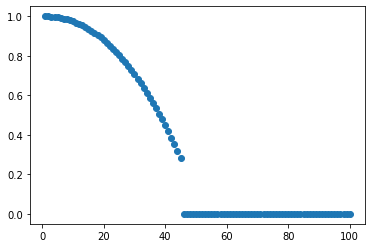

In [30]:
def fg_model(yds):
    exp = 2.2 
    y_end = .67
    in_range = yds <= 45
    return in_range + yds**(exp)*((y_end-1)/2000)*in_range

yds = pd.Series(np.arange(1,101))
plt.scatter(yds, fg_model(yds))

### Fourth down conversion probability
**You can skip reading this section if you are pressed for time. Run the code cell to import the model.**  

We used the `conversion_data` calculated above to fit a Scikit-learn RandomForest classification model to estimate the probability that the offense converts on fourth down at a given distance from the line to gain. 

The probability decays quickly as the distance increases.

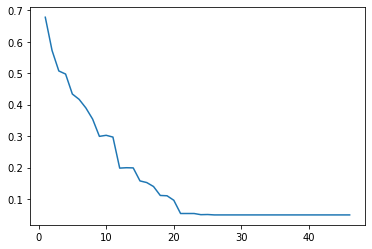

In [31]:
with open('resource/asnlib/publicdata/convert_clf.pkl', 'rb') as f:
    convert_clf = pickle.load(f)

distance = pd.Series(np.linspace(1, 46, 46, endpoint=True))

def conversion_model(distance):
    d = distance.values.reshape((-1,1))
    return convert_clf.predict_proba(d)[:,1]

plt.plot(distance, conversion_model(distance))

### Expected points  
**You can skip reading this section if you are pressed for time. Run the code cell to import the model.**  

This is probably the least intuitive metric we're estimating. The idea is that the state of the game (down, distance, yards to the endzone) has an unrealized effect on what the final score will be. We attempt to quantify this effect by estimating the point value of the next scoring play based on the state of the game. 

We fit a Scikit-learn Linear Regression model based on the `down`, `distance`, and `yardsToEndzone` fields from the `ep_data` calculated above. In the plot, the colors (blue, orange, green, and red) represent first, second, third, and fourth down, respectively. The distance is frozen at the minimum of 10 and the distance to the endzone (hence the "bend" on the left). We see that expected points step down with each down and increase as the ball is closer to the endzone. 

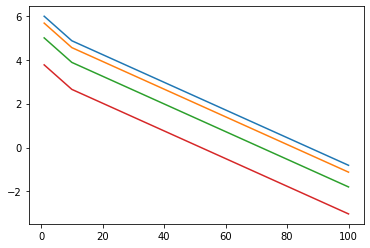

In [32]:
with open('resource/asnlib/publicdata/ep_est.pkl', 'rb') as f:
    ep_est = pickle.load(f)
    
def ep_model(df):
    _df = pd.get_dummies(df, columns=['down'])
    for i in range(1,5):
        check_col = f'down_{i}'
        if check_col not in _df.columns:
            _df[check_col] = 0
    _df = _df.loc[:, ['down_1', 'down_2', 'down_3',
       'down_4', 'distance', 'yardsToEndzone']]
    return ep_est.predict(_df)

base_data = pd.DataFrame({
    'down': [0]*100,
    'distance': [10]*100,
    'yardsToEndzone': np.linspace(1, 100, 100, endpoint=True)
})
base_data.loc[base_data['yardsToEndzone'] < base_data['distance'], 'distance'] = base_data['yardsToEndzone']

for i in range(1,5):
    df = base_data.copy()
    df['down'] = i
    plt.plot(df['yardsToEndzone'], ep_model(df))

### Win probability

**The important takeaway here is the two formulas for $\mu$ and $\sigma$. You will use those later. Don't worry about the integral or the explanation if you're pressed for time.**

We're not using a fancy machine learning model to estimate win probability. Instead, we're going to adapt what [Pro-football Reference uses](https://www.pro-football-reference.com/about/win_prob.htm). It works pretty well. Teams with the lead get higher probabilities as the game goes on. Here's the premise:

Assuming evenly matched teams the point differential at the start of an NFL game is modeled by a random variable $X\sim\mathcal{N}(\mu, \sigma)$ with $\mu=0$ and $\sigma=13.85$. 
  
As the game is played, the score becomes less variable. We adjust the model for time by scaling down the standard deviation. The in-game formula for the standard deviation is  
$$\sigma = \frac{13.85}{\sqrt{\frac{3600}{1 + \text{timeLeft}}}}$$

We also move the mean to account for the current point differential as well as the expected points from the field position. The in-game formula for the mean is as follows ($\text{EP}_{\text{offense}}$ is the expected points for the offense).  

$$\mu = \text{homeTeamPoss}\left[\text{homeScore} + \text{EP}_{\text{offense}} - \text{awayScore}\right] + $$
$$(1-\text{homeTeamPoss})\left[\text{awayScore} + \text{EP}_{\text{offense}} - \text{homeScore}\right]$$

The following improper integral can be used to calculate the win probability for the team on offense by plugging in for $\mu$ and $\sigma$.  
$$1-\int_{-\infty}^{0.5}\frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right)dx$$


## Exercise 7 - (**2** Points): 
First off - you're not going to have to compute that integral! There's actually no closed form solution, and almost nobody likes a Taylor Series expansion by hand.  Instead we're going to let the `scipy.stats.norm` module do the heavy lifting. We have already imported it under the name `norm`.

`norm.cdf(t, mu, sigma)` computes 
$$F(t, \mu, \sigma) = \int_{-\infty}^{t}\frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right)dx$$
  
Define the function `win_prob_model(df: pd.DataFrame) -> np.ndarray`
- Input: `df` (DataFrame) - will include fields `homeScore`, `awayScore`, `down`, `distance`, `homeTeamPoss`, `yardsToEndzone`, `timeLeft`  

Your solution should do the following:
- Compute $\text{EP}_{\text{offense}}$ by using the `ep_model` function provided. It takes a DataFrame (including at least `down` and `distance`, extra fields are fine) and returns an array.
- Compute $\mu$ using the formula from the cell above. _Recall that boolean values of True equate to integer values of 1 and boolean values of False equate to integer values of 0._
- Compute $\sigma$ using the formula from the cell above.
- Compute $1 - F(0.5, \mu, \sigma)$ using `norm.cdf` as described above and return the result.

**Pro-tip** Don't forget the "one minus" part of the final result.

In [33]:
### Define demo inputs
with open('resource/asnlib/publicdata/demo_df_ex7', 'rb') as f:
    demo_df_ex7 = pickle.load(f)
demo_df_ex7

,homeScore,awayScore,down,distance,homeTeamPoss,yardsToEndzone,timeLeft
0,10,10,2,14,False,79,2387
1,19,7,2,10,False,26,1698
2,52,0,4,14,False,90,227
3,10,17,2,3,True,60,230
4,12,0,4,2,False,2,2437
5,17,38,3,2,True,41,1092
7,9,14,1,10,False,47,1718
8,10,0,4,8,False,26,3046
9,26,24,4,16,False,64,238


<!-- Expected demo output text block -->
For your intermediate calculations of `mu` and `sigma` you should get the following approximate values:  

|    |          mu |    sigma |  
|---:|------------:|---------:|  
|  0 |  -0.0429587 | 11.2802  |  
|  1 |  -8.45817   |  9.5147  |  
|  2 | -54.6385    |  3.48551 |  
|  3 |  -5.17341   |  3.50836 |  
|  4 |  -8.35904   | 11.3977  |  
|  5 | -18.5881    |  7.63148 |  
|  7 |   7.53041   |  9.57054 |  
|  8 |  -8.23825   | 12.7419  |  
|  9 |  -3.12201   |  3.5686  |  

The demo included in the solution cell below should display the following output:
```
array([0.48080476, 0.17322218, 0.        , 0.05292715, 0.21850005,
       0.00618805, 0.76870511, 0.24642358, 0.15506048])
```
<!-- Include any shout outs here -->

In [34]:
### Exercise 7 solution
def win_prob_model(df: pd.DataFrame) -> np.ndarray:
    ###
    offense_ep = ep_model(df)
    mu = (offense_ep+df['homeScore']-df['awayScore']) * df['homeTeamPoss'] + \
        (offense_ep+df['awayScore']-df['homeScore']) * (1 - df['homeTeamPoss']) 
    sigma = 13.85 / np.sqrt((3600)/(1 + df['timeLeft']))
    return 1 - norm.cdf(0.5, loc=mu, scale=sigma)
    ###
    
#   Compute EPoffense by using the ep_model function provided. 
#     It takes a DataFrame (including at least down and distance, extra fields are fine) and returns an array.

# μ=homeTeamPoss[homeScore+EPoffense−awayScore]+ homeTeamPoss[homeScore+EPoffense−awayScore]+
# (1−homeTeamPoss)[awayScore+EPoffense−homeScore]

#   Compute μ using the formula from the cell above. 
#     Recall that boolean values of True equate to integer values of 1 and boolean values of False equate to integer values of 0.

#   Compute σ using the formula from the cell above.

#   Compute 1−F(0.5,μ,σ)1−F(0.5,μ,σ) using norm.cdf as described above and return the result.

### demo function call
win_prob_model(demo_df_ex7)

array([0.48080476, 0.17322218, 0.        , 0.05292715, 0.21850005,
       0.00618805, 0.76870511, 0.24642358, 0.15506048])

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 7. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [35]:
### test_cell_ex7
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_7', 
    'func': win_prob_model, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'np.ndarray',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## Putting it all together

**You can skip this if you are pressed for time**

### Expected outcomes from the decisions.
At the start of the notebook our stated goal was to build a tool to provide data driven guidance. There's actually two parts to being able to provide the proper guidance. One is being able to model how likely certain events are to occur in a given game situation. That we have accomplished. The second piece is to simulate all of the possible outcomes from a decision so that we can feed them into our win probability model. That we haven't touched, and it actually involves a fair bit of football knowledge. For the sake of sparing the less football-savy among us and keeping this notebook from being _even longer_ we have implemented simulations for all 5 potential outcomes and imported.

- `simulate_punt(df) -> df`: returns the expected outcome from a **punt** for all game situations described by `df`.
- `simulate_fg_make(df) -> df`: returns the expected outcome from a **made field goal** for all game situations described by `df`.
- `sumulate_fg_miss(df) -> df`: returns the expected outcome from a **missed field goal** for all game situations described by `df`.
- `simulate_fourth_down_succeed(df) -> df`: returns the expected outcome from a **successful play attempt** for all game situations described by `df`.
- `simulate_fourth_down_fail(df) -> df`: returns the expected outcome from a **failed play attempt** for all game situations described by `df`.

All functions take an input `df` and return an output `df` with the fields `'event_id', 'play_id', 'down', 'distance', 'yardsToEndzone', 'timeLeft', 'awayScore', 'homeScore', 'homeTeamPoss', 'won'`. The returned output will have the `'down', 'distance', 'yardsToEndzone', 'timeLeft', 'awayScore', 'homeScore', 'homeTeamPoss'` columns modified to reflect the changes in field position, game time, score, and possession expected from each outcome. 

If you want to look at the implementation details they are available in `football_utils.py`.



## Exercise 8 - (**3** Points): 
Last exercise. Buckle up! 

**Note: This exercise depends on Exercise 7**

We want to make a decision model that will evaluate whether a team has the best chance of winning the game given the choice of three options:
  - **Run a play** - Has two outcomes. Succeed or fail.
  - **Attempt a field goal** - Has two outcomes. Make or miss.
  - **Punt** - Has only one outcome.

Complete `sim_outcomes(df: pd.DataFrame, models: dict) -> pd.DataFrame`

**There is a _lot_ that goes into this decision model. We have done much of the heavy lifting for you by completing all but the final steps. In the starter code we processed the inputs and produced the following variables for you to use**
- `go_succeed_prob` (array) - $Pr(\text{succeed})$ - the **probability of the "succeed"** outcome for the **"run a play"** choice for each row in `df`.
- `fg_make_prob` (array) -  $Pr(\text{make})$ - The **probability of the "make"** outcome of the **"attempt a field goal"** choicefor each row in `df`.
- `df_punt` (DataFrame) - The state of the game after the **"punt"** decision for each row in `df`.
- `def_win_prob_model` (function) - Given a DataFrame, like `punt_df`, returns an array of the win probabilities for each row. 
- `df` - a copy of the input with the following new columns:
  - `succeed_wp`: $Pr(\text{win}\mid \text{succeed})$ - The win probability if the "succeed" outcome of the "run a play" choice occurs for each row in `df`.
  - `fail_wp`: $Pr(\text{win}\mid \neg \text{succeed})$ - The win probability if the "fail" outcome of the "run a play" choice occurs for each row in `df`.
  - `fg_make_wp`: $Pr(\text{win}\mid \text{make})$ - The win probability if the "make" outcome of the "attempt a field goal" choice occurs for each row in `df`.
  - `fg_miss_wp`: $Pr(\text{win}\mid \neg \text{make})$ - The win probability if the "miss" outcome of the "attempt a field goal" choice occurs for each row in `df`.
  
**Your Task:**
Finish off the function by **adding these columns** to `df` and **rounding** numerical columns to **4 decimal** places:
- `punt_wp`: Win probability for each row in `df_punt`
- `kick_wp`: $Pr(\text{win}\mid (\text{make OR } \neg \text{make}))$
- `go_wp`: $Pr(\text{win}\mid (\text{succeed OR } \neg \text{succeed}))$


Recall the following from statistics concerning binary events: 
  - If $Pr(A)$ is the probability of event $A$ occurring then $Pr(\neg A) = 1-Pr(A)$ is the probability of event $A$ not occurring.
  - If event $B$ depends on event $A$ occurring then $Pr(B \mid (A \text{ OR } \neg A)) = Pr(B\mid A)Pr(A) + Pr(B\mid \neg A)Pr(\neg A)$

In [36]:
### Define demo inputs
with open('resource/asnlib/publicdata/demo_df_ex8', 'rb') as f:
    demo_df_ex8 = pickle.load(f)

<!-- Expected demo output text block -->
The demo included in the solution cell below should display the following output (It's wide, you may have to scroll):   

|    |   homeScore |   awayScore |   down |   distance | homeTeamPoss   |   yardsToEndzone |   timeLeft |   go_succeed_prob |   fg_make_prob |   fg_make_wp |   fg_miss_wp |   fail_wp |   succeed_wp |   punt_wp |   kick_wp |   go_wp |
|---:|------------:|------------:|-------:|-----------:|:---------------|-----------------:|-----------:|------------------:|---------------:|-------------:|-------------:|----------:|-------------:|----------:|----------:|--------:|
|  0 |           7 |           0 |      4 |          1 | False          |                1 |       1904 |            0.6785 |         0.9998 |       0.3358 |       0.2691 |    0.2838 |       0.4895 |    0.2546 |    0.3358 |  0.4233 |
|  1 |           7 |           0 |      4 |          7 | True           |               26 |       2566 |            0.3898 |         0.786  |       0.7976 |       0.703  |    0.7214 |       0.8222 |    0.7359 |    0.7773 |  0.7607 |
|  2 |          21 |           0 |      4 |          8 | False          |               69 |       1965 |            0.3542 |         0      |       0.037  |       0.0083 |    0.01   |       0.0261 |    0.0181 |    0.0083 |  0.0157 |
|  3 |          19 |          31 |      4 |          1 | False          |               66 |        335 |            0.6785 |         0      |       0.9998 |       0.9808 |    0.9852 |       0.9989 |    0.9976 |    0.9808 |  0.9945 |
|  5 |          19 |          23 |      4 |          7 | True           |               27 |       1085 |            0.3898 |         0.7675 |       0.4338 |       0.2622 |    0.29   |       0.4859 |    0.3157 |    0.3939 |  0.3664 |
|  6 |          17 |           7 |      4 |          3 | False          |               41 |       1982 |            0.5075 |         0.4171 |       0.2396 |       0.127  |    0.1375 |       0.2355 |    0.1737 |    0.1739 |  0.1872 |
|  7 |           7 |          22 |      4 |          2 | False          |                2 |        737 |            0.5727 |         0.9992 |       0.9977 |       0.9941 |    0.9953 |       0.9997 |    0.9932 |    0.9977 |  0.9979 |
|  9 |           7 |           6 |      4 |         10 | True           |               46 |       1851 |            0.3028 |         0      |       0.6467 |       0.4586 |    0.489  |       0.6463 |    0.5823 |    0.4586 |  0.5366 |


<!-- Include any shout outs here -->

In [37]:
### Exercise 8 solution
def sim_outcomes(df: pd.DataFrame, models: dict) -> pd.DataFrame:
    conversion_model = models['convert']
    fg_model = models['fg']
    win_prob_model = models['win_prob']
    def_win_prob_model = lambda d: 1 - win_prob_model(d)
    df = df.copy()
    goal_to_go = df['distance'] == df['yardsToEndzone']
    fg_make_prob = fg_model(df['yardsToEndzone'])
    go_succeed_prob = conversion_model(df['distance'])
    df['go_succeed_prob'] = go_succeed_prob
    df['fg_make_prob'] = fg_make_prob
    # Make columns for win probability if a particular outcome occurs
    df['fg_make_wp'] = def_win_prob_model(simulate_fg_make(df))
    df['fg_miss_wp'] = def_win_prob_model(simulate_fg_miss(df))
    df['fail_wp'] = def_win_prob_model(simulate_fourth_down_fail(df))
    df.loc[goal_to_go, 'succeed_wp'] = def_win_prob_model(simulate_fourth_down_succeed(df))[goal_to_go]
    df.loc[~goal_to_go, 'succeed_wp'] = win_prob_model(simulate_fourth_down_succeed(df))[~goal_to_go]
    # Make df_punt
    df_punt = simulate_punt(df)
    
    ###
    fg_miss_prob = 1-fg_make_prob
    go_fail_prob = 1-go_succeed_prob
    df['punt_wp'] = def_win_prob_model(df_punt)
    df['kick_wp'] = fg_make_prob*df['fg_make_wp'] + fg_miss_prob*df['fg_miss_wp']
    df['go_wp'] = go_succeed_prob*df['succeed_wp'] + go_fail_prob*df['fail_wp']
    return df.round(4)
    ###
    
### demo function call
models = {
    'convert': conversion_model,
    'fg': fg_model,
    'win_prob': win_prob_model
}
sim_outcomes(demo_df_ex8, models)

,homeScore,awayScore,down,distance,homeTeamPoss,yardsToEndzone,timeLeft,go_succeed_prob,fg_make_prob,fg_make_wp,fg_miss_wp,fail_wp,succeed_wp,punt_wp,kick_wp,go_wp
0,7,0,4,1,False,1,1904,0.6785,0.9998,0.3358,0.2691,0.2838,0.4895,0.2546,0.3358,0.4233
1,7,0,4,7,True,26,2566,0.3898,0.7860,0.7976,0.7030,0.7214,0.8222,0.7359,0.7773,0.7607
2,21,0,4,8,False,69,1965,0.3542,0.0000,0.0370,0.0083,0.0100,0.0261,0.0181,0.0083,0.0157
3,19,31,4,1,False,66,335,0.6785,0.0000,0.9998,0.9808,0.9852,0.9989,0.9976,0.9808,0.9945
5,19,23,4,7,True,27,1085,0.3898,0.7675,0.4338,0.2622,0.2900,0.4859,0.3157,0.3939,0.3664
6,17,7,4,3,False,41,1982,0.5075,0.4171,0.2396,0.1270,0.1375,0.2355,0.1737,0.1739,0.1872
7,7,22,4,2,False,2,737,0.5727,0.9992,0.9977,0.9941,0.9953,0.9997,0.9932,0.9977,0.9979
9,7,6,4,10,True,46,1851,0.3028,0.0000,0.6467,0.4586,0.4890,0.6463,0.5823,0.4586,0.5366


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 9. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [ ]:
### test_cell_ex8
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_9', 
    'func': sim_outcomes, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        },'models':{
            'dtype':'dict', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'qni4-JKoB2OXw7cdPu6VxK1dNkBTJmEW6jYuJjRdBEg=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

**Fin.** If you have made it this far, congratulations on completing the exam. **Don't forget to submit!**